### Dependencies

In [1]:
# Install dependencies
!conda update -n base -c defaults conda

!conda install --yes --file ../requirements.txt

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



### Imports

In [2]:
# Torch
import torch

# Torch Vision
import torchvision

# Path
from pathlib import Path

# Matplot
import matplotlib.pyplot as pp

### GPU

In [3]:
# Check if GPU is available
try:
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
except:
    print('CPU')

GeForce MX150


### Pre-processing <a name="pre-processing"></a>

The train dataset is loaded, resized, transformed to tensor and normalized. Data augmentation is applied, expanding the dataset of 6552 images to 39312 images.

The resize and normalization happen to enable the usage of pre-trained models weights. The normalization causes weirdo behaviors, the channels `0` and `2` have a huge amount of data transformed to `inf` ([constants](https://www.numpy.org/devdocs/reference/constants.html)), it can be a property expected by the networks. An example of the pre-processing required by trained models, [Alex Net](https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101).

The validation dataset is loaded, resized and normalized; its use is validate the train, then doesn't make sense to apply other transformations to the dataset.

The test dataset is a split of the validation dataset, 654 images are split to validation and 164 images to test.

In [4]:
def load(path = '.', transform = torchvision.transforms.ToTensor(), batch_size = 64, shuffle = True, num_workers = 0):
    '''
        Load dataset
        
        Parameters
        ----------
        
        path: str
            Dataset path
        
        transform: torchvision.transforms
            Transform function
        
        batch_size: int
            Batch size
        
        shuffle: bool
            Reshuffle data
        
        num_workers: int
            Subprocesses
            
        Usage
        -----
        
        >>> load()
        
        Return
        ------
        
        Data Loader object
        
        References
        ----------
        
        https://discuss.pytorch.org/t/how-to-load-png-using-dataloader/17079/2
        
        https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
        
        https://pytorch.org/docs/stable/torchvision/transforms.html
        
        https://github.com/marvis/pytorch-yolo2/issues/89
        
        https://discuss.pytorch.org/t/how-can-i-load-a-number-of-images/12468/8
        
        https://github.com/pytorch/pytorch/issues/8976
        
        Observation
        -----------
        
        In some cases, the loading of data using multiple works break the application, see references  for more details
    '''
    
    pth = Path(path)
    
    if not pth.exists() or not pth.is_dir():
        raise Exception('Incompatible path')
    
    return torch.utils.data.DataLoader(
        dataset=torchvision.datasets.ImageFolder(
            root=path,
            transform=transform
        ),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers        
    )


def plot(axe, images, cmap = 'gray', title = '', color = False):
    '''
        Plot images
        
        Parameters
        ----------
        
        axe: matplotlib.pyplot.subplots
            Matplot buffer
        
        images: torch.tensor
            Tensor matrix
            
        cmap: str
            Color map
        
        title: str
            Matrix title
        
        color: bool
            RGB images
            
        Usage
        -----
        
        2D Images (gray)
        
        >>> fig, ax = pp.subplots(nrows=2, ncols=2, figsize=(2, 2))
        >>>
        >>> plot(ax, [torch.randn((4, 4)) for image in range(0, 4)])
        
        3D Images (rgb)
        
        >>> fig, ax = pp.subplots(nrows=2, ncols=2, figsize=(2, 2))
        >>>
        >>> plot(ax, [torch.randn((4, 4, 3)) for image in range(0, 4)], color = True)
        
        Return
        ------
        
        None
        
        References
        ----------
        
        https://matplotlib.org/examples/color/colormaps_reference.html
        
        https://matplotlib.org/api/axes_api.html
        
        http://matplotlib.1069221.n5.nabble.com/display-image-as-r-g-b-from-a-3xMxN-nympy-array-td2398.html
        
        https://stackoverflow.com/questions/53181846/matplotlib-plt-show-visual-glitch-when-pre-indexing-empty-numpy-array
        
        https://discuss.pytorch.org/t/convert-to-numpy-cuda-variable/499
        
        Observation
        -----------
        
        If the plot break happens, try to set `pp.ion()` or `%matplotlib inline` to activate the iterative mode. The error
        'clipping input data to the valid range for imshow with RGB data' ca be caused by some data normalization or
        corrupted / inexistent channels.        
    '''
    
    count = 0
    
    for row in range(axe.shape[0]):
        for col in range(axe.shape[1]):
            if color:
                axe[row, col].imshow(images[count].numpy().transpose((1, 2, 0)))
            else:
                axe[row, col].imshow(images[count].numpy().squeeze(), cmap=cmap)
            
            axe[row, col].axis('off')
            
            if title:
                axe[row, col].set_title(title)
            
            count += 1

In [5]:
# Train dataset
height_train, width_train = 224, 224

train_batch_size = 64

train_num_workers = 0

normalize = torchvision.transforms.Normalize(mean=[0.5], std=[0.5])  # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

transform_train = [
    torchvision.transforms.Resize((height_train, width_train)),
    torchvision.transforms.ToTensor(),
    normalize
]

# Train 1
train1 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(transform_train)
)

# Train 2
_train2 = transform_train.copy()

_train2.insert(1, torchvision.transforms.RandomRotation((30, 360)))

train2 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train2)
)

# Train 3
_train3 = transform_train.copy()

_train3.insert(1, torchvision.transforms.ColorJitter(brightness = 2.0, hue = 0.5, saturation = 0.5))

train3 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train3)
)

# Train 4
_train4 = transform_train.copy()

_train4.insert(1, torchvision.transforms.RandomCrop(size=(height_train / 2, width_train / 2)))

_train4.insert(2, torchvision.transforms.Resize(size=(height_train, width_train)))

train4 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train4)
)

# Train 5
_train5 = transform_train.copy()

_train5.insert(1, torchvision.transforms.RandomHorizontalFlip(p = 1.0))

_train5.insert(2, torchvision.transforms.RandomVerticalFlip(p = 1.0))

train5 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train5)
)

# Train 6
_train6 = transform_train.copy()

_train6.insert(1, torchvision.transforms.RandomAffine((30, 360), fillcolor = 0))

train6 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train6)
)

# Concat datasets
train_vectors = [
    {'title': 'Original', 'data': train1},
    {'title': 'Rotation', 'data': train2},
    {'title': 'Brightness', 'data': train3},
    {'title': 'Crop', 'data': train4},
    {'title': 'Flip', 'data': train5},
    {'title': 'Affine', 'data': train6}
]

train = torch.utils.data.ConcatDataset([
    item['data'].dataset for item in train_vectors
])

train = torch.utils.data.DataLoader(
    train,
    batch_size = 1,  # https://medium.com/@yvanscher/pytorch-tip-yielding-image-sizes-6a776eb4115b
    shuffle = True,
    num_workers = train_num_workers
)
    
print(f'Train dataset length: {len(train.dataset)}')

Train dataset length: 39312


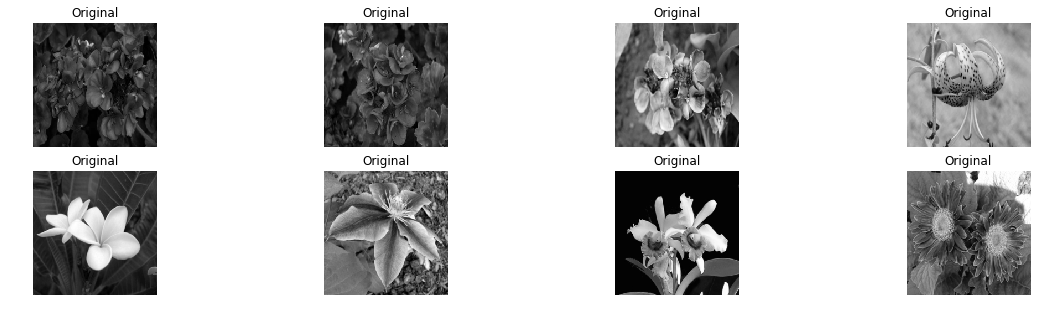

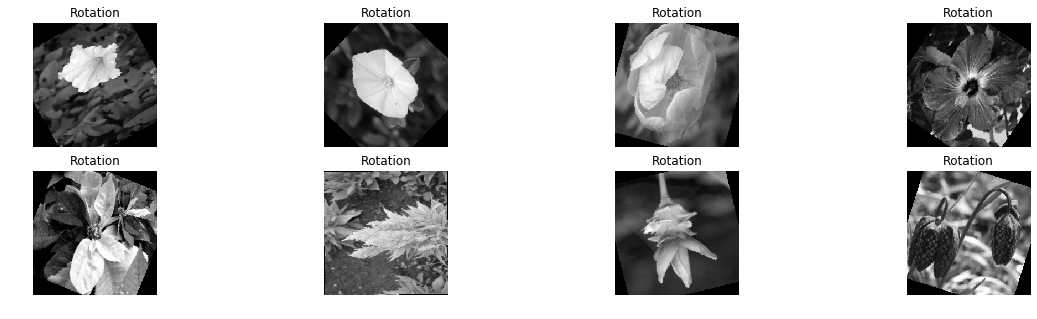

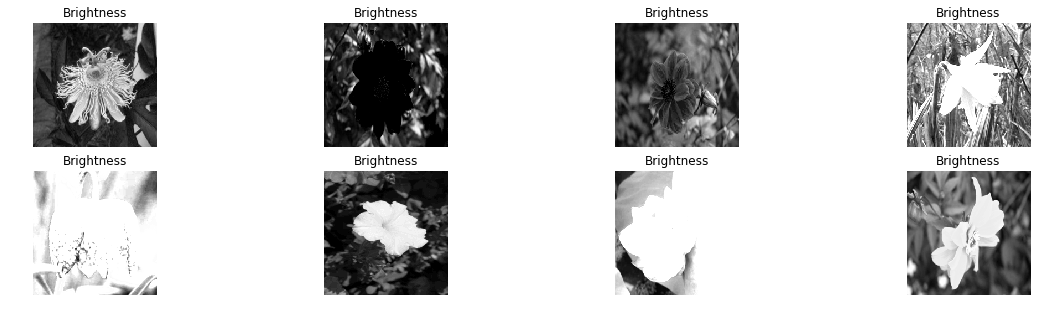

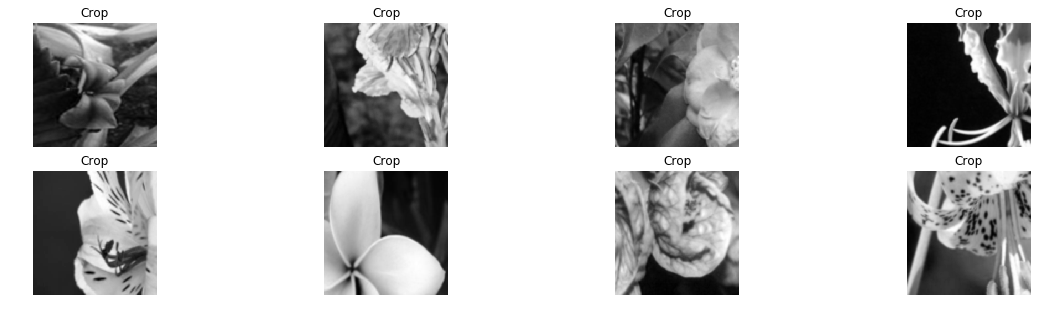

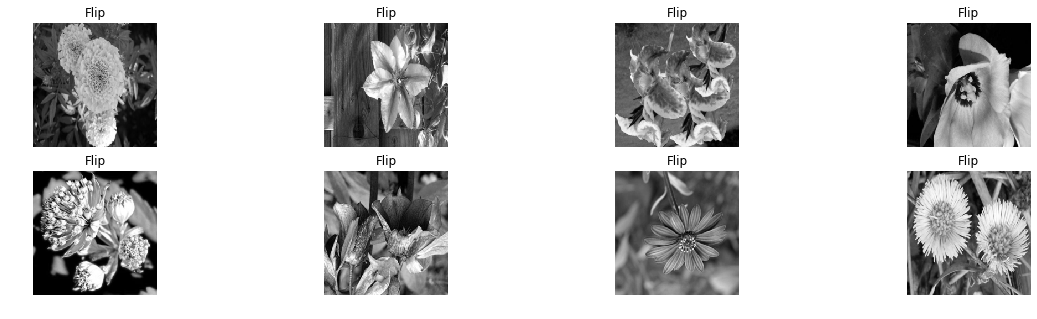

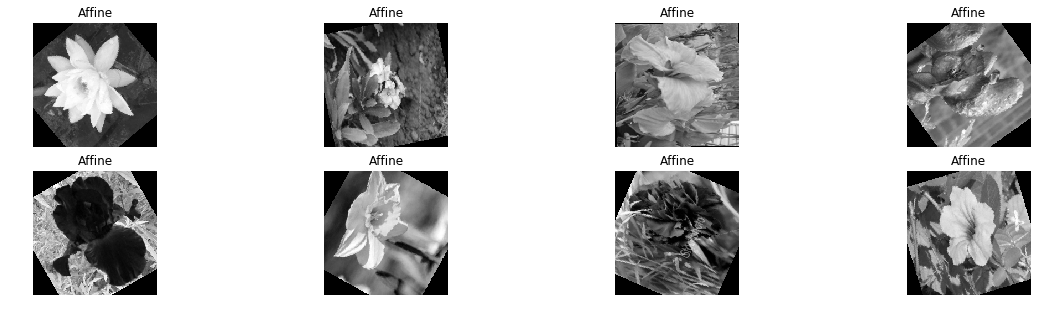

In [6]:
# Plot train dataset
%matplotlib inline

for item in train_vectors:
    # Get epoch
    images_train, labels_train = iter(item['data']).next()
    
    # Plot images
    figure, axe = pp.subplots(nrows=2, ncols=4, figsize=(20, 5))
    
    # plot(axe = axe, images = images_train, color = True, title = item['title'])  # RGB (disable the normalization)
    
    plot(axe = axe, images = images_train[:, 1], title = item['title'])

In [7]:
# Validation dataset
height_validation, width_validation = 224, 224

validation_batch_size = 64

validation_num_workers = 10

transform_validation = [
    torchvision.transforms.Resize((height_validation, width_validation)),
    torchvision.transforms.ToTensor(),
    normalize
]

# Validation
validation = load(
    path='../data/valid',
    transform=torchvision.transforms.Compose(transform_validation)
)

print(f'Validation dataset length: {len(validation.dataset)}')

Validation dataset length: 818


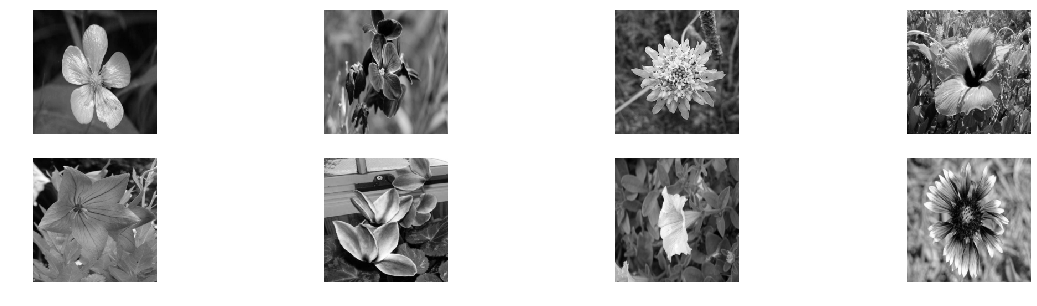

In [8]:
# Plot validation dataset
%matplotlib inline

dataiter = iter(validation)

images_validation, labels_validation = dataiter.next()

# Plot images
figure, axe = pp.subplots(nrows=2, ncols=4, figsize=(20, 5))

plot(axe = axe, images = images_validation[:, 1])

In [9]:
# Test dataset
validation_size = int(0.8 * len(validation.dataset))

test_size = int(len(validation.dataset) - validation_size)

validation, test = torch.utils.data.random_split(validation.dataset, [validation_size, test_size])

print(len(validation), len(test))  # 654 164

654 164


### Models

The usage of pre-trained models require some transformations, see the [documentation](https://pytorch.org/docs/stable/torchvision/models.html#torchvision-models) or the [pre-processing](#pre-processing) section of this notebook to get more details. The the freezed layers can be found on `~/.torch/models`.

Architecture references, read the papers [rethinking the inception architecture for computer vision](https://arxiv.org/abs/1512.00567) and [deep residual learning for image recognition](https://arxiv.org/abs/1512.03385) ([talk](https://www.youtube.com/watch?v=C6tLw-rPQ2o)).

In [10]:
# Create the models (https://github.com/pytorch/examples/blob/master/imagenet/main.py#L256)
resnet18 = torchvision.models.resnet18(pretrained=True)

inception = torchvision.models.inception_v3(pretrained=True)

In [ ]:
# Train resnet
resnet18.train()

criterion = torch.nn.MSELoss()  # Mean square error

optimizer = torch.optim.Adam(resnet18.parameters())

for count, (image, label) in enumerate(train):
    # Set the gradient of all model to zero
    optimizer.zero_grad()
    
    # Compute the output
    output = resnet18(image)
    
    # Compute the loss
    loss = criterion(output.float(), label.float())
    
    # Retro propagate
    loss.backward()
    
    optimizer.step()
    
    # Measure
    print('Epoch [{0}]: {1} loss'.format(count, loss))